# Analysis of stellar spectra


## Background Information on the dataset


You will be working with spectra of stars that have been aquired by the space telescope Gaia (https://www.esa.int/Science_Exploration/Space_Science/Gaia). 

For part of these stars, we have additional information from another observation mission GALAH (https://www.galah-survey.org/) that observed some of these stars as well. This will provide us with some labels for part of the dataset, but we don't (and can't, at the moment) know the "truth" for the stars that have not been observed by GALAH.


spectra are 1D data were each feature corresponds to a wavelength. Here the spectra span a wavelength range of 846–870 nm, with a step of 0.01 nm. 

### Data matrix:

spec_rvs_wise_galah.npy (spectra from Gaia for stars observed by both Gaia and GALAH)  = 21556 spectra of size 2401 each. We refer to it later as spectra_withgalah.
\
spec_NOgalah_rvswise.npy ((spectra from Gaia for stars observed only by Gaia) = 22295 spectra of size 2401 each. we refer to it later as spectraNOgal 

### Additional information dataframe:
gaiaGalah_info_rvswisegalah = information for the stars observed by both GALAH and Gaia (we refer to it later as gaiagal_info)
\
gaia_info_rvswiseNOgalah = information (partial) for the stars only observed by Gaia

### Indexing files:
(This shouldn't be necessary, as the spectra matrix and the dataframe should have the right order, but just in case)

ids_rvs_wise_galah = corresponding IDs of the spectra in spec_rvs_wise_galah (corresponds to "dr3_source_id" in gaiaGalah_info_rvswisegalah
\
ids_NOgalah_rvswise = corresponding IDs of the spectra in spec_rvs_wise_galah (corresponds to "source_id" in gaiaGalah_info_rvswisegalah




Example of a spectrum from the dataset: 

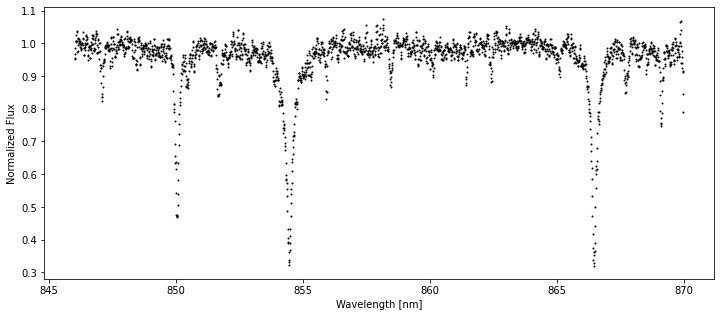


Spectras contain information about the composition of a star through absorbtion and emission lines:


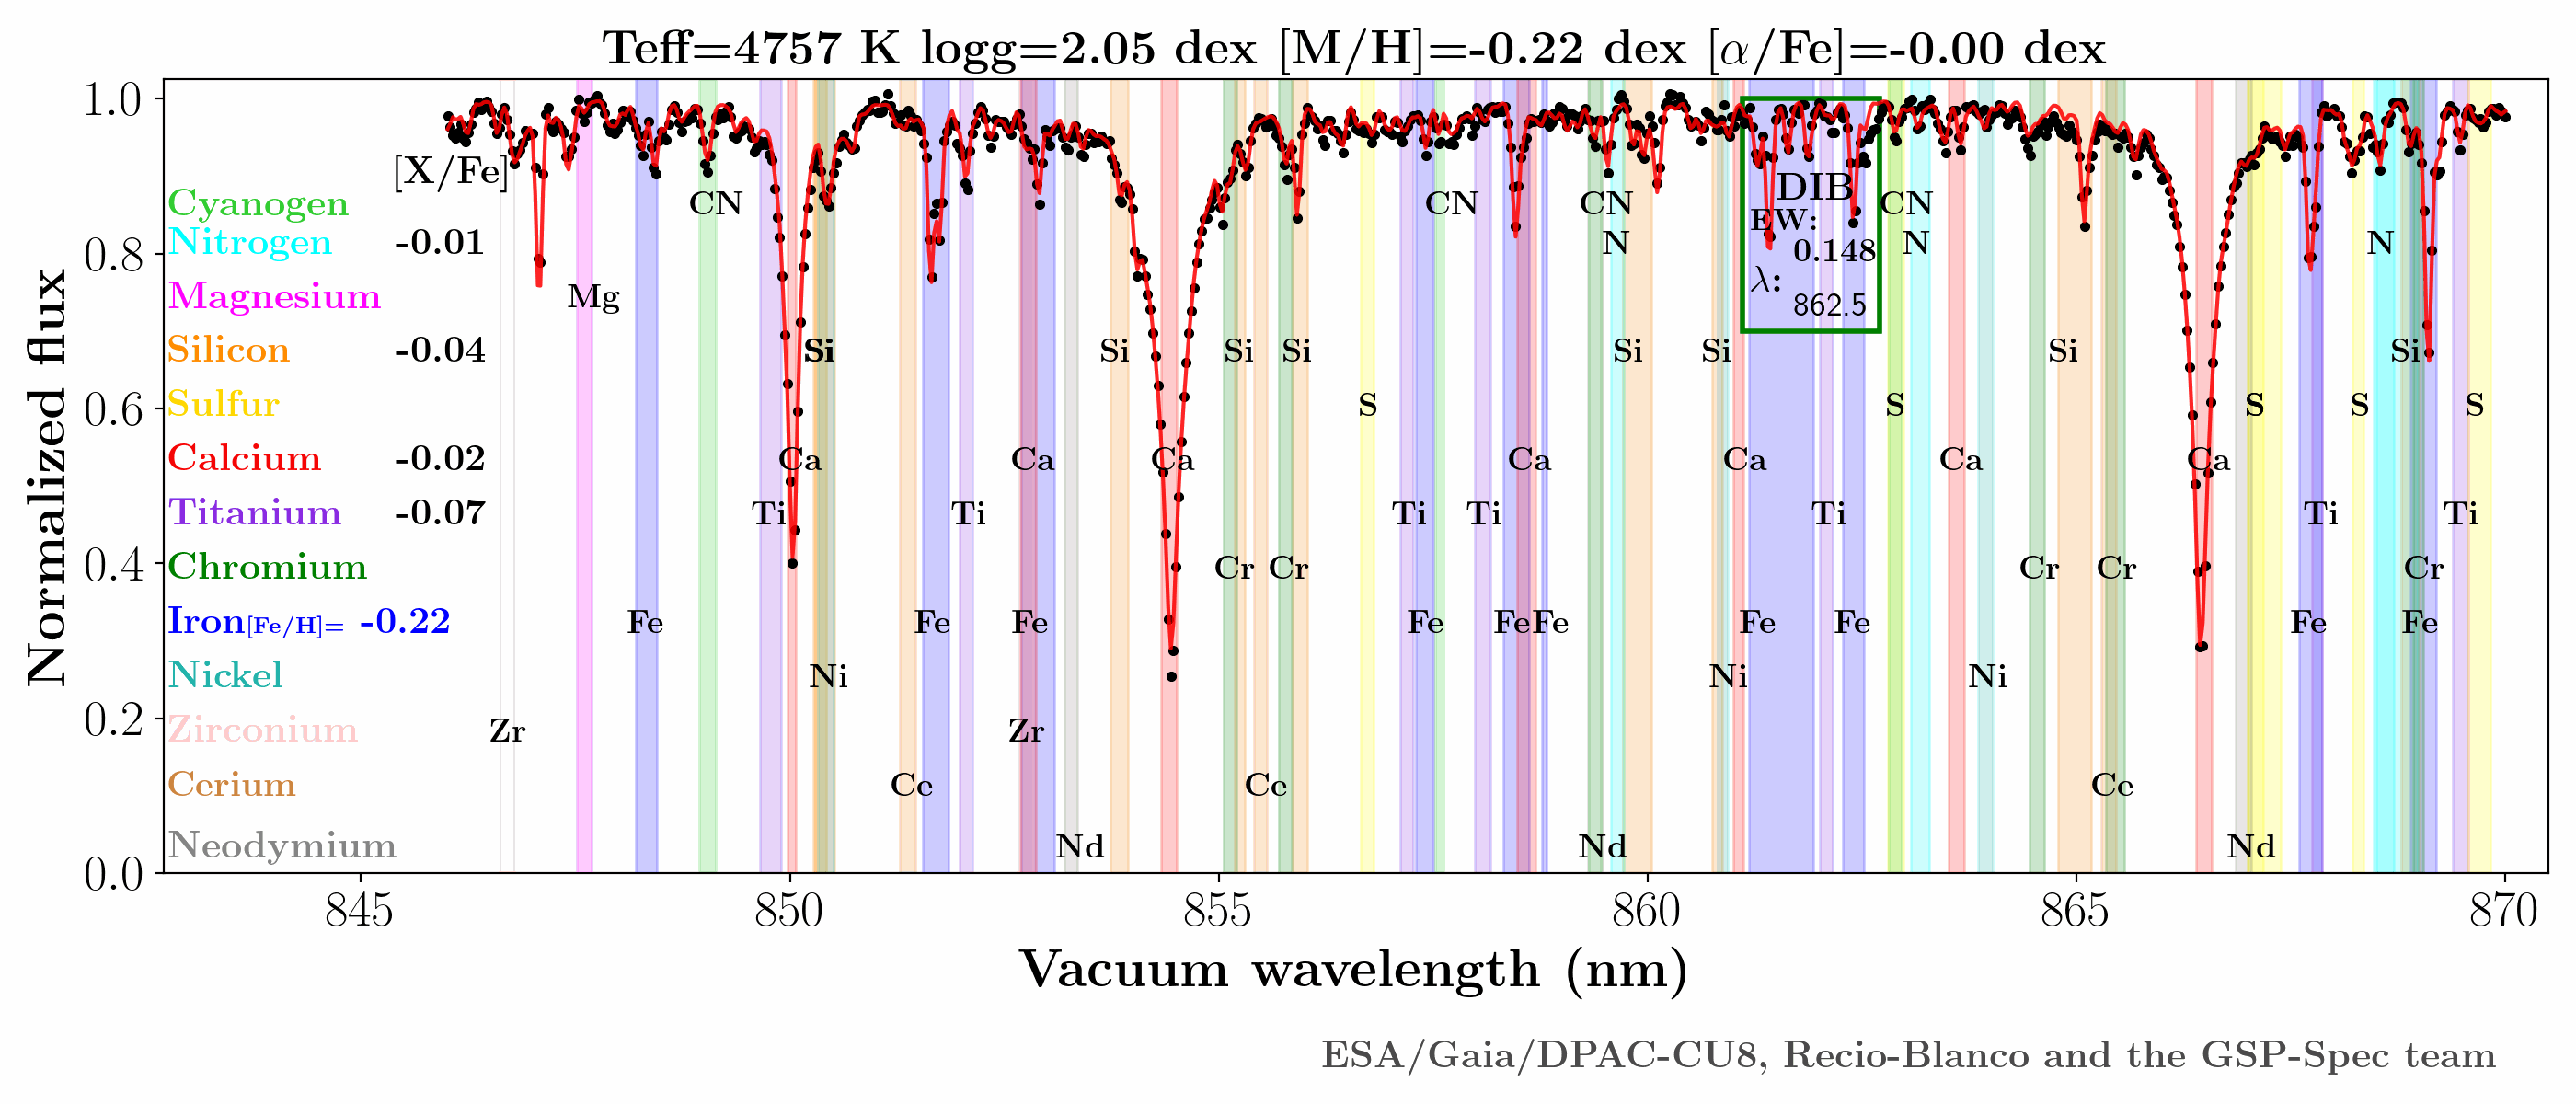

https://www.cosmos.esa.int/web/gaia/iow_20210709#

Different types of stars will have different looking spectras.
However, the spectra we get from Gaia are on a small range of wavelength, and not all interactions/emissions are known, neither necessarily the types of stars! 
On the other hand, GALAH observed those stars at larger wavelengths range (verify) and thus was able to produce some labels about metallicities and so on. 

One question that might be interesting to ask is: is there enough information from the Gaia spectra to predict those labels --we just don't know yet the "physically informed" way of doing it, but maybe it is possible! 

We're also interested in finding out if we see patterns or clusters in our dataset: they might indicate different type of stars (or, spoiler alert, observational issues...). 
Anomalies are also of interest, either finding extremely rare objects that we need to explain, or data impacted by observational artifact (most likely). 

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer



### Pre-processing

The spectra are in normalized flux, so they don't need to much pre-processing. However, **some spectra can contain NaN values; replace those values by the median of the given spectrum (i.e. of that row of the matrix) before carrying on!**  (your code will most likely crash if you don't anyway.)

Note the spectra file are .npy format you can load with numpy; the information tables can be loaded with pandas.

In [2]:
# Load the .npy file using numpy
data_dir = './data/'

spectra_withgalah_np = np.load(data_dir + 'spec_rvs_wise_galah.npy')
spectra_withgalah = pd.DataFrame(spectra_withgalah_np)

spectraNOgal_np = np.load(data_dir + "spec_NOgalah_rvswise.npy")
spectraNOgal = pd.DataFrame(spectraNOgal_np)

gaiagal_info = pd.read_csv(data_dir + "gaia_info_rvswisegalah.csv")
gaiaNOgal_info = pd.read_csv(data_dir + "gaia_info_rvswiseNOgalah.csv")

Print number of NaN

In [3]:
print("Number of NaN for each dataset")
print("Spectra with galah =", spectra_withgalah.isna().sum().sum())
print("Spectra NO gal =", spectraNOgal.isna().sum().sum())
print("Gaia info =", gaiagal_info.isna().sum().sum())
print("Gaia NO gal =", gaiaNOgal_info.isna().sum().sum())

Number of NaN for each dataset


Spectra with galah = 131180
Spectra NO gal = 147436
Gaia info = 704326
Gaia NO gal = 731018


Impute data by the median of the given spectrum

In [4]:
imputer = SimpleImputer(strategy='median')
spectra_withgalah.iloc[:,:] = imputer.fit_transform(spectra_withgalah.iloc[:,:])
spectraNOgal.iloc[:,:] = imputer.fit_transform(spectraNOgal.iloc[:,:])

In [5]:
print("Number of NaN for each dataset")
print("Spectra with galah =", spectra_withgalah.isna().sum().sum())
print("Spectra NO gal =", spectraNOgal.isna().sum().sum())

Number of NaN for each dataset
Spectra with galah = 0
Spectra NO gal = 0


In [6]:
imputer = SimpleImputer(strategy='median')
# gaiagal_info.iloc[:,:] = imputer.fit_transform(gaiagal_info.iloc[:,:])
# gaiaNOgal_info.iloc[:,:] = imputer.fit_transform(gaiaNOgal_info.iloc[:,:])

In [7]:
print("Number of NaN for each dataset")
# print("Gaia info =", gaiagal_info.isna().sum().sum())
# print("Gaia NO gal =", gaiaNOgal_info.isna().sum().sum())

Number of NaN for each dataset


Try to plot a few spectra to see if you see differences between them!

### Metallicity Regression

One measurement that is interesting to astronomers is "metallicity". This can mean different thing, but in the context of this project, we will be considering the column "fe_h" in gaiagal_info. We will use this as our label for the regression task.\
For now, we can only use the spectra_withgalah / gaiagal_info since they are the only ones with this information. Since we need supervision for this task, ensure that you have proper labels for all your spectra --some might have a NaN fe_h! 


Build a pipeline for this regression problem: construct a training and test set from the data, and train models to predict.Try (e.g. using sklearn) RandomForestRegressor (explore different hyper-parameters), LinearRegressor, and KNeighborsRegressor.\
You can plot the true labels (x-axis) vs the predicted labels (y-axis), for the train and test data.\
Summarize the error in prediction (using the Mean Square Error) for the models in a table.


## Visualization and dimensionality reduction exploration

Apply PCA on the spectra_withgalah, and \
  a) plot the explained variance ratio as a function of the number of components; \
  b) plot scatter plots of the lower-dimensional PCA-transformed space using few components (e.g. using the 0th/1st components, 0th/2d); what do you observe? \
  c) plot the first 3 PCA components (i.e. in "spectra" space) 
  
 

Apply PCA on the other spectra dataset (spec_NOgalah_rvswise) and compare the results (specifically b) and c)). 


(Optional): Try another algorithm for visualization/dimensionality reduction like t-SNE or UMAP.

#### Loading the libraries

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

Perform PCA on spectra_withgalah

In [9]:
N_pca = 20
pca_withgalah = PCA(n_components=N_pca, random_state=42)
spectra_withgalah_pca = pca_withgalah.fit_transform(spectra_withgalah)

In [10]:
print("dataset dimension: ", spectra_withgalah.shape)

dataset dimension:  (21556, 2401)


Plot the explained variance ratio for the first 10 components

In [11]:
total_explained_variance = np.sum(pca_withgalah.explained_variance_ratio_)
print("Total Explained Variance for 'WithGala' dataset:", total_explained_variance)
pca_withgala_group_variance = np.zeros((N_pca,))
for k in range (0,N_pca):
    pca_withgala_group_variance[k] = sum(pca_withgalah.explained_variance_ratio_[0:k])

Total Explained Variance for 'WithGala' dataset: 0.45259127


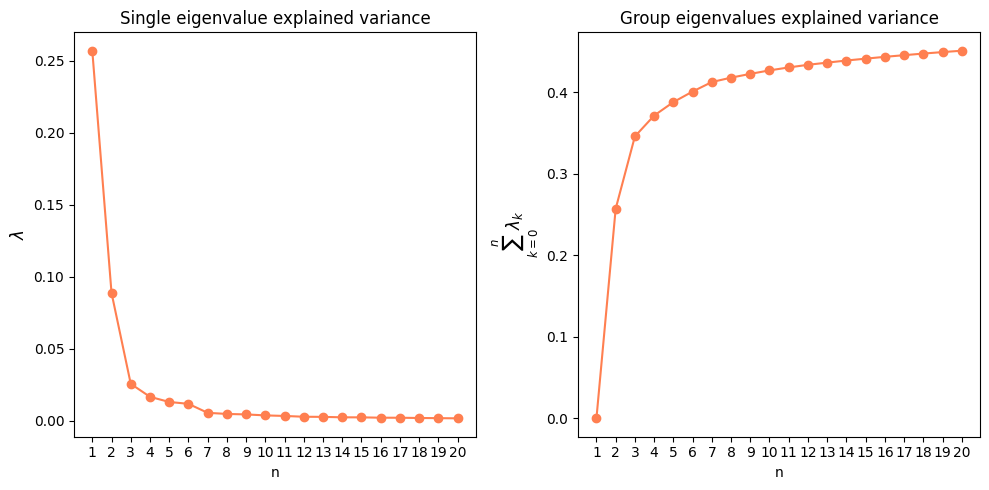

In [12]:
# Create a figure with 1 row and 2 columns for side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# First plot (on the left)
axs[0].plot(np.arange(1, 21), pca_withgalah.explained_variance_ratio_[0:20], marker='o', color = 'coral')
axs[0].set_title('Single eigenvalue explained variance')
axs[0].set_ylabel('$\lambda$', fontsize=12)
axs[0].set_xlabel('n')
axs[0].set_xticks(np.arange(1, 21))
#axs[0].legend()

# Second plot (on the right)
axs[1].plot(np.arange(1, 21), pca_withgala_group_variance, marker='o',color = 'coral')
axs[1].set_title('Group eigenvalues explained variance')
axs[1].set_ylabel('$\sum_{k=0}^n\lambda_k$', fontsize=12)
axs[1].set_xlabel('n')
axs[1].set_xticks(np.arange(1, 21))
#axs[1].legend()


# Adjust layout to avoid overlap
plt.tight_layout()


#### Generate Scatter Plots of PCA-Transformed Data

Scatter plot: Component 0 vs Component 1

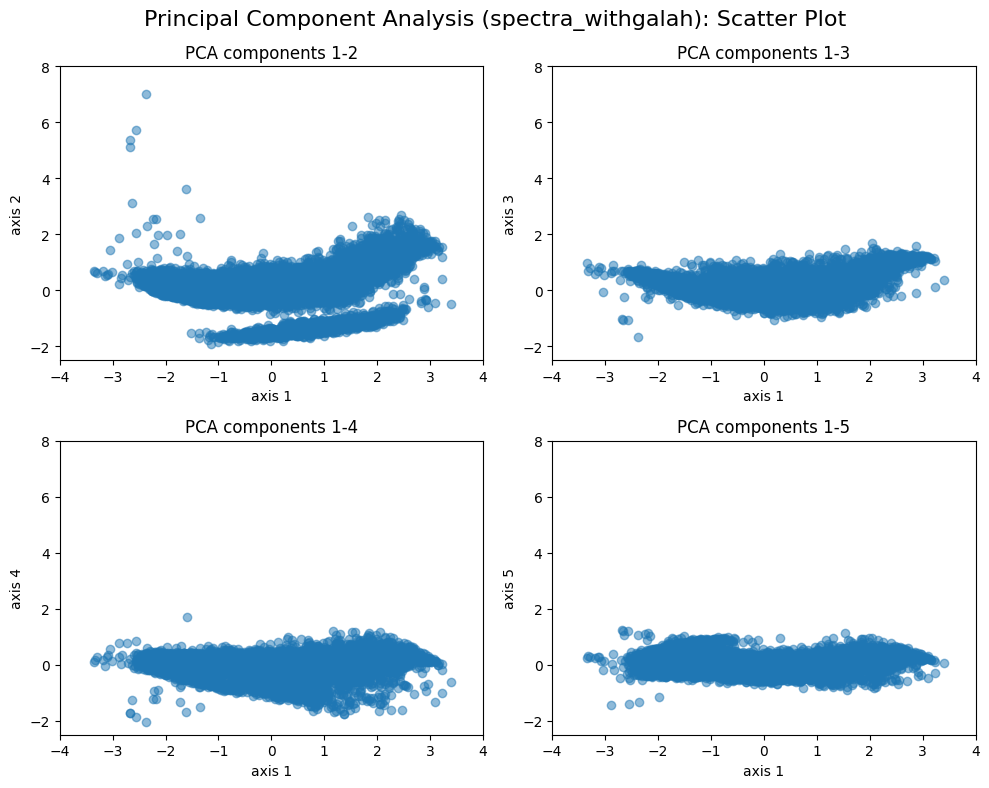

In [13]:
# Create a figure with 1 row and 2 columns for side-by-side plots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# First plot (on the left)
axs[0,0].scatter(spectra_withgalah_pca[:, 0], spectra_withgalah_pca[:, 1], alpha=0.5)
axs[0,0].set_title('PCA components 1-2')
axs[0,0].set_xlabel('axis 1')
axs[0,0].set_ylabel('axis 2')
#axs[0,0].legend()
axs[0,0].set_xlim(-4, 4)
axs[0,0].set_ylim(-2.5, 8)

# Second plot (on the right)
axs[0,1].scatter(spectra_withgalah_pca[:, 0], spectra_withgalah_pca[:, 2], alpha=0.5)
axs[0,1].set_title('PCA components 1-3')
axs[0,1].set_xlabel('axis 1')
axs[0,1].set_ylabel('axis 3')
#axs[0,1].legend()
axs[0,1].set_xlim(-4, 4)
axs[0,1].set_ylim(-2.5, 8)

# First plot (on the left)
axs[1,0].scatter(spectra_withgalah_pca[:, 0], spectra_withgalah_pca[:, 3], alpha=0.5)
axs[1,0].set_title('PCA components 1-4')
axs[1,0].set_xlabel('axis 1')
axs[1,0].set_ylabel('axis 4')
#axs[1,0].legend()
axs[1,0].set_xlim(-4, 4)
axs[1,0].set_ylim(-2.5, 8)

# Second plot (on the right)
axs[1,1].scatter(spectra_withgalah_pca[:, 0], spectra_withgalah_pca[:, 4], alpha=0.5)
axs[1,1].set_title('PCA components 1-5')
axs[1,1].set_xlabel('axis 1')
axs[1,1].set_ylabel('axis 5')
#axs[0,1].legend()
axs[1,1].set_xlim(-4, 4)
axs[1,1].set_ylim(-2.5, 8)

fig.suptitle('Principal Component Analysis (spectra_withgalah): Scatter Plot', fontsize=16)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

#### Reconstruct and Plot the First 3 PCA Components in the Original Spectra Space

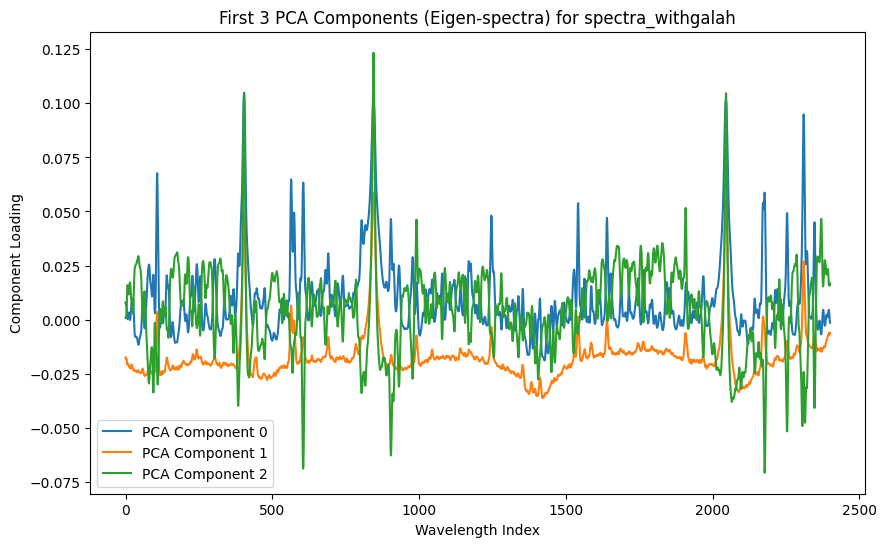

In [14]:
plt.figure(figsize=(10,6))
for i in range(3):
    plt.plot(pca_withgalah.components_[i], label=f'PCA Component {i}')
plt.title("First 3 PCA Components (Eigen-spectra) for spectra_withgalah")
plt.xlabel("Wavelength Index")
plt.ylabel("Component Loading")
plt.legend()
plt.show()

#### Repeat the PCA Analysis on the spectraNOgal Dataset

Explained Variance Ratio

In [15]:
# Perform PCA on spectraNOgal
pca_nogal = PCA(n_components=20, random_state=42)
spectraNOgal_pca = pca_nogal.fit_transform(spectraNOgal)

In [16]:
total_explained_variance = np.sum(pca_nogal.explained_variance_ratio_)
print("Total Explained Variance for 'NoGala' dataset:", total_explained_variance)
set_explained_variances = np.zeros((N_pca,))
for k in range (0,N_pca):
    set_explained_variances[k] = sum(pca_nogal.explained_variance_ratio_[0:k])

Total Explained Variance for 'NoGala' dataset: 0.6473644


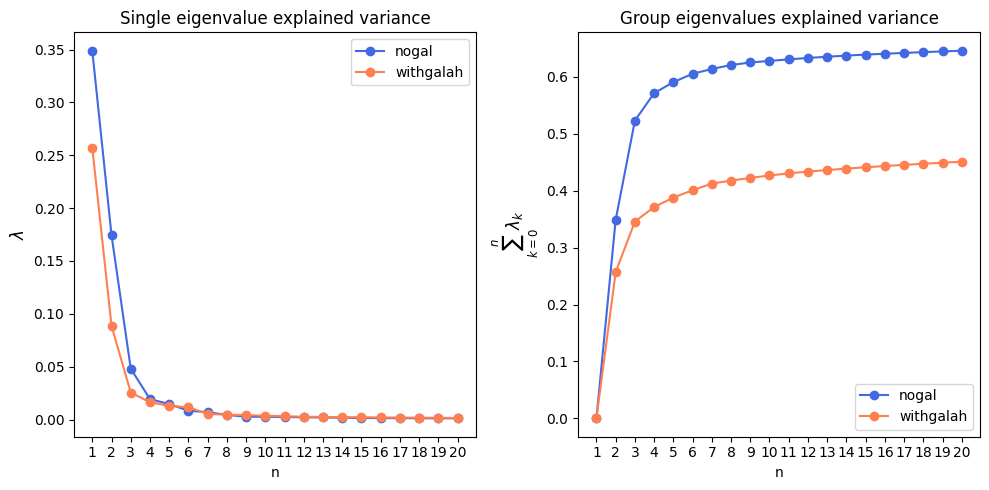

In [17]:
# Create a figure with 1 row and 2 columns for side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# First plot (on the left)
axs[0].plot(np.arange(1, 21), pca_nogal.explained_variance_ratio_[0:20], marker='o', color = 'royalblue', label='nogal')
axs[0].plot(np.arange(1, 21), pca_withgalah.explained_variance_ratio_[0:20], marker='o', color = 'coral', label='withgalah')
axs[0].set_title('Single eigenvalue explained variance')
axs[0].set_ylabel('$\lambda$', fontsize=12)
axs[0].set_xlabel('n')
axs[0].set_xticks(np.arange(1, 21))
axs[0].legend()

# Second plot (on the right)
axs[1].plot(np.arange(1, 21), set_explained_variances, marker='o',color='royalblue', label='nogal')
# axs[1].plot(np.arange(1, 20), set_explained_variances[1:]-pca_nogal.explained_variance_ratio_[0], marker='o',color='royalblue')
axs[1].plot(np.arange(1, 21), pca_withgala_group_variance, marker='o',color='coral', label='withgalah')
axs[1].set_title('Group eigenvalues explained variance')
axs[1].set_ylabel('$\sum_{k=0}^n\lambda_k$', fontsize=12)
axs[1].set_xlabel('n')
axs[1].set_xticks(np.arange(1, 21))
axs[1].legend()


# Adjust layout to avoid overlap
plt.tight_layout()

Scatter Plots of PCA-Transformed Data

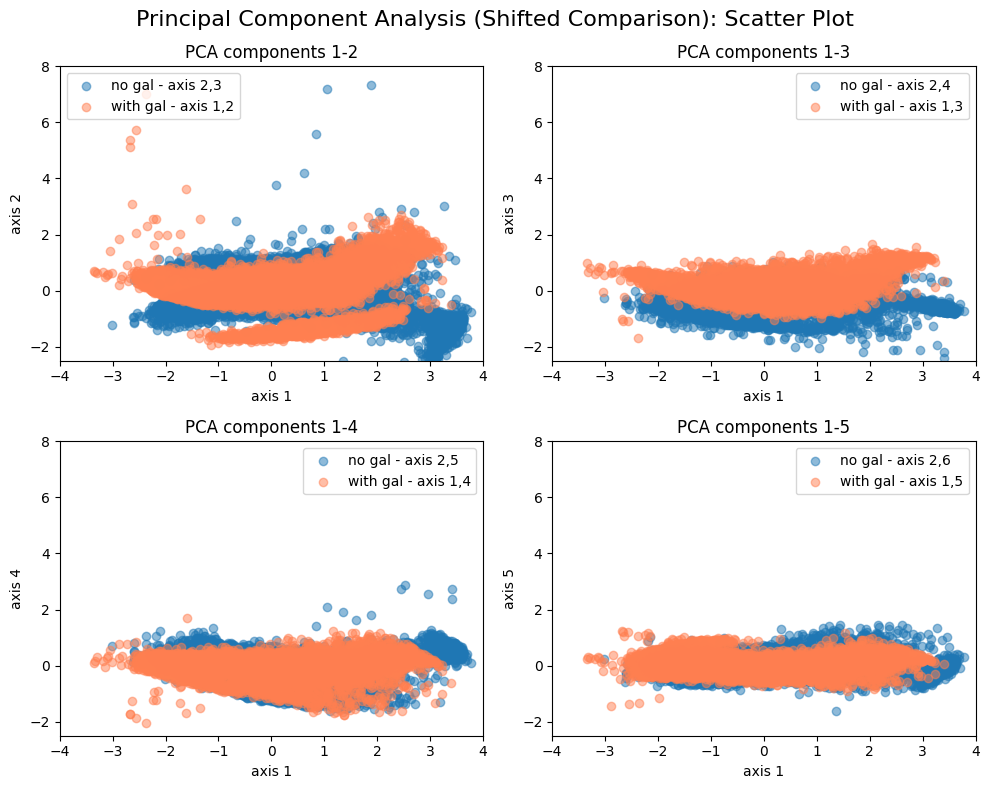

In [18]:
# Create a figure with 1 row and 2 columns for side-by-side plots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# First plot (on the left)

axs[0,0].scatter(spectraNOgal_pca[:, 1], spectraNOgal_pca[:, 2], alpha=0.5, label = 'no gal - axis 2,3')
axs[0,0].scatter(spectra_withgalah_pca[:, 0], spectra_withgalah_pca[:, 1], alpha=0.5, color = 'coral', label = 'with gal - axis 1,2')
axs[0,0].set_title('PCA components 1-2')
axs[0,0].set_xlabel('axis 1')
axs[0,0].set_ylabel('axis 2')
axs[0,0].legend()
axs[0,0].set_xlim(-4, 4)
axs[0,0].set_ylim(-2.5, 8)

# Second plot (on the right)
axs[0,1].scatter(spectraNOgal_pca[:, 1], spectraNOgal_pca[:, 3], alpha=0.5, label = 'no gal - axis 2,4')
axs[0,1].scatter(spectra_withgalah_pca[:, 0], spectra_withgalah_pca[:, 2], alpha=0.5, color = 'coral', label = 'with gal - axis 1,3')
axs[0,1].set_title('PCA components 1-3')
axs[0,1].set_xlabel('axis 1')
axs[0,1].set_ylabel('axis 3')
axs[0,1].legend()
axs[0,1].set_xlim(-4, 4)
axs[0,1].set_ylim(-2.5, 8)

# First plot (on the left)
axs[1,0].scatter(spectraNOgal_pca[:, 1], spectraNOgal_pca[:, 4], alpha=0.5, label = 'no gal - axis 2,5')
axs[1,0].scatter(spectra_withgalah_pca[:, 0], spectra_withgalah_pca[:, 3], alpha=0.5, color = 'coral', label = 'with gal - axis 1,4')
axs[1,0].set_title('PCA components 1-4')
axs[1,0].set_xlabel('axis 1')
axs[1,0].set_ylabel('axis 4')
axs[1,0].legend()
axs[1,0].set_xlim(-4, 4)
axs[1,0].set_ylim(-2.5, 8)

# Second plot (on the right)
axs[1,1].scatter(spectraNOgal_pca[:, 1], spectraNOgal_pca[:, 5], alpha=0.5, label = 'no gal - axis 2,6')
axs[1,1].scatter(spectra_withgalah_pca[:, 0], spectra_withgalah_pca[:, 4], alpha=0.5, color = 'coral', label = 'with gal - axis 1,5')
axs[1,1].set_title('PCA components 1-5')
axs[1,1].set_xlabel('axis 1')
axs[1,1].set_ylabel('axis 5')
axs[1,1].legend()
axs[1,1].set_xlim(-4, 4)
axs[1,1].set_ylim(-2.5, 8)

fig.suptitle('Principal Component Analysis (Shifted Comparison): Scatter Plot', fontsize=16)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

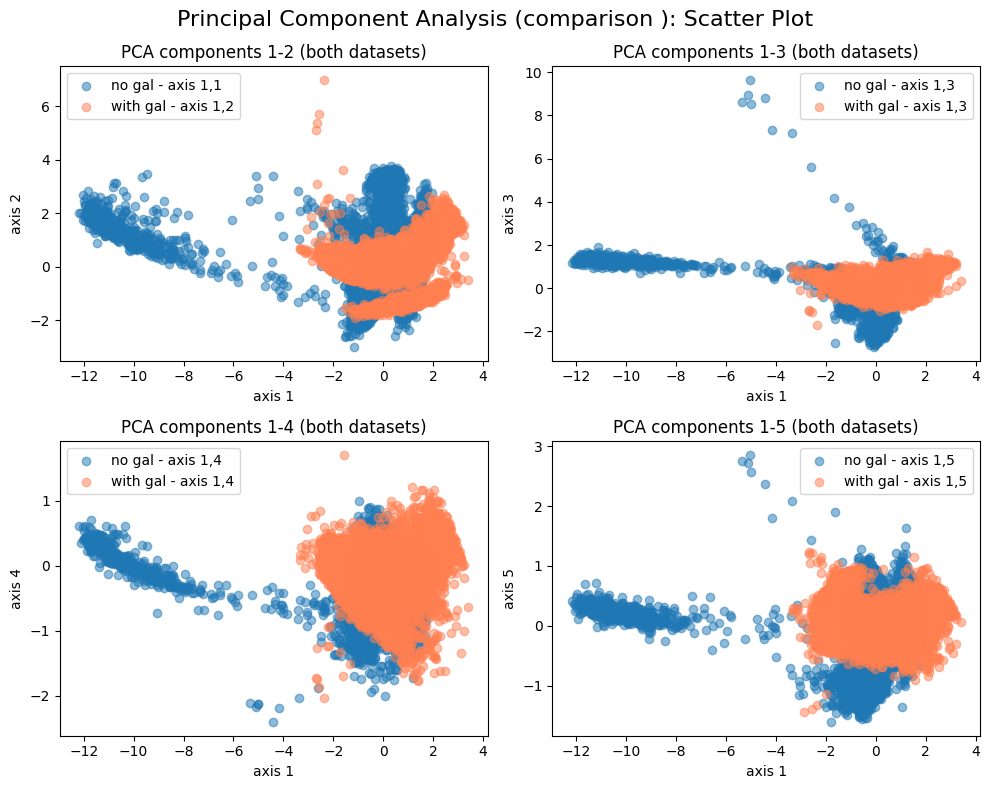

In [19]:
# Create a figure with 1 row and 2 columns for side-by-side plots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# First plot (on the left)

axs[0,0].scatter(spectraNOgal_pca[:, 0], spectraNOgal_pca[:, 1], alpha=0.5, label = 'no gal - axis 1,1')
axs[0,0].scatter(spectra_withgalah_pca[:, 0], spectra_withgalah_pca[:, 1], alpha=0.5, color = 'coral', label = 'with gal - axis 1,2')
axs[0,0].set_title('PCA components 1-2 (both datasets)')
axs[0,0].set_xlabel('axis 1')
axs[0,0].set_ylabel('axis 2')
axs[0,0].legend()
# axs[0,0].set_xlim(-4, 4)
# axs[0,0].set_ylim(-2.5, 8)

# Second plot (on the right)
axs[0,1].scatter(spectraNOgal_pca[:, 0], spectraNOgal_pca[:, 2], alpha=0.5, label = 'no gal - axis 1,3')
axs[0,1].scatter(spectra_withgalah_pca[:, 0], spectra_withgalah_pca[:, 2], alpha=0.5, color = 'coral', label = 'with gal - axis 1,3')
axs[0,1].set_title('PCA components 1-3 (both datasets)')
axs[0,1].set_xlabel('axis 1')
axs[0,1].set_ylabel('axis 3')
axs[0,1].legend()
# axs[0,1].set_xlim(-4, 4)
# axs[0,1].set_ylim(-2.5, 8)

# First plot (on the left)
axs[1,0].scatter(spectraNOgal_pca[:, 0], spectraNOgal_pca[:, 3], alpha=0.5, label = 'no gal - axis 1,4')
axs[1,0].scatter(spectra_withgalah_pca[:, 0], spectra_withgalah_pca[:, 3], alpha=0.5, color = 'coral', label = 'with gal - axis 1,4')
axs[1,0].set_title('PCA components 1-4 (both datasets)')
axs[1,0].set_xlabel('axis 1')
axs[1,0].set_ylabel('axis 4')
axs[1,0].legend()
# axs[1,0].set_xlim(-4, 4)
# axs[1,0].set_ylim(-2.5, 8)

# Second plot (on the right)
axs[1,1].scatter(spectraNOgal_pca[:, 0], spectraNOgal_pca[:, 4], alpha=0.5, label = 'no gal - axis 1,5')
axs[1,1].scatter(spectra_withgalah_pca[:, 0], spectra_withgalah_pca[:, 4], alpha=0.5, color = 'coral', label = 'with gal - axis 1,5')
axs[1,1].set_title('PCA components 1-5 (both datasets)')
axs[1,1].set_xlabel('axis 1')
axs[1,1].set_ylabel('axis 5')
axs[1,1].legend()
# axs[1,1].set_xlim(-4, 4)
# axs[1,1].set_ylim(-2.5, 8)

fig.suptitle('Principal Component Analysis (comparison ): Scatter Plot', fontsize=16)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

Reconstruct and Plot the First 3 PCA Components in the Original Spectra Space

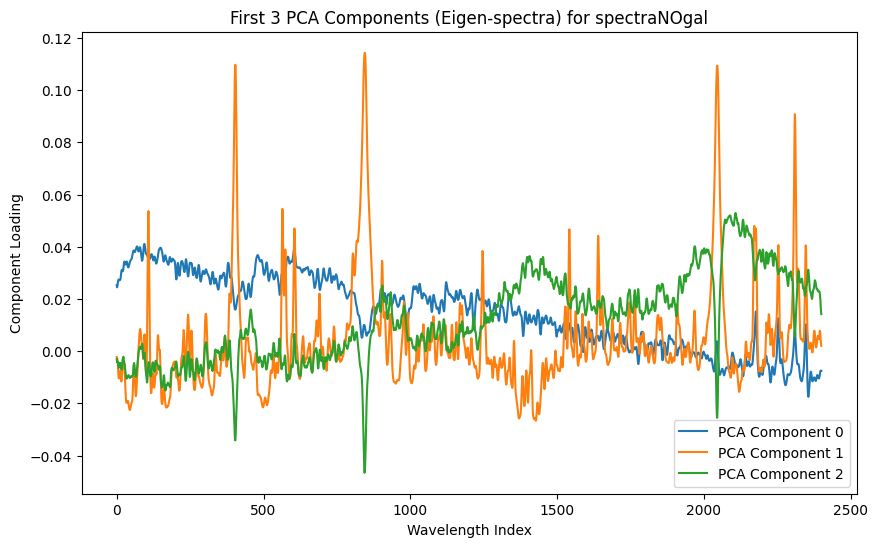

In [20]:
plt.figure(figsize=(10,6))
for i in range(3):
    plt.plot(pca_nogal.components_[i], label=f'PCA Component {i}')
plt.title("First 3 PCA Components (Eigen-spectra) for spectraNOgal")
plt.xlabel("Wavelength Index")
plt.ylabel("Component Loading")
plt.legend()
plt.show()

## Clustering

Using the lower dimensional space from PCA (e.g. with even only 2 or 3 components) on the spectraNOgal dataset, run a clustering algorithm to separate your data. \
For each of the cluster you find, plot the average spectra of this cluster. 

#### Loading the libraries

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

### Clustering on PCA-Reduced Data

PCA for withgalah dataset

In [46]:
pca_withgalah = PCA(n_components=3, random_state=552)
pca_withgalah_data = pca_withgalah.fit_transform(spectra_withgalah)
print(pca_withgalah_data.shape)

(21556, 3)


PCA for nogalah dataset

In [47]:
pca_nogal = PCA(n_components=3, random_state=552)
pca_nogal_data = pca_nogal.fit_transform(spectraNOgal)
print(pca_nogal_data.shape)

(22295, 3)


#### Run K-Means clustering on the PCA-transformed data

In [48]:
n_clusters = 2

# withgalah
kmeans_withgalah = KMeans(n_clusters=n_clusters, random_state=552)
clusters_withgalah = kmeans_withgalah.fit_predict(pca_withgalah_data)

# previous PCA analysis indicates that there should be an extra cluster on nogal
n_clusters = 3 

# nogal
kmeans_nogal = KMeans(n_clusters=n_clusters, random_state=552)
clusters_nogal = kmeans_nogal.fit_predict(pca_nogal_data)

2D PCA projection for visualization

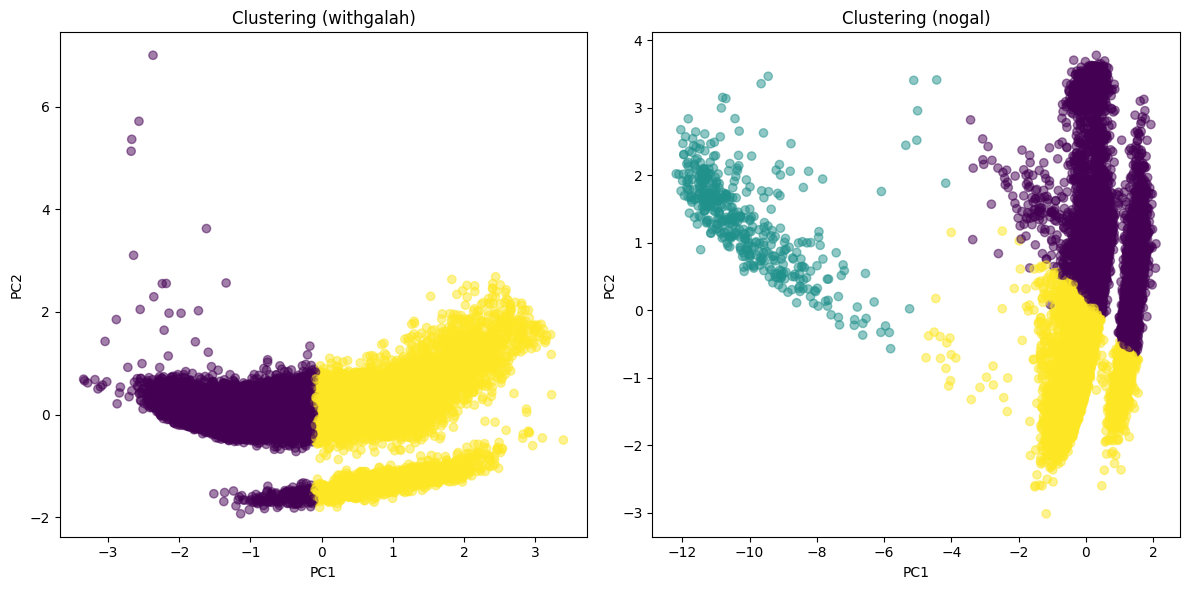

In [49]:
pca_withgalah_2d = PCA(n_components=2, random_state=552).fit_transform(spectra_withgalah)
pca_nogal_2d = PCA(n_components=2, random_state=552).fit_transform(spectraNOgal)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(pca_withgalah_2d[:, 0], pca_withgalah_2d[:, 1],
            c=clusters_withgalah, cmap='viridis', alpha=0.5)
plt.title("Clustering (withgalah)")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.subplot(1, 2, 2)
plt.scatter(pca_nogal_2d[:, 0], pca_nogal_2d[:, 1],
            c=clusters_nogal, cmap='viridis', alpha=0.5)
plt.title("Clustering (nogal)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


Our cluster analysis reveals that while the nogal dataset largely overlaps with the withgalah dataset, indicating consistent spectral features across most of the data, it also exhibits an additional, distinct cluster. 

As we will discuss later, examination of the average spectra suggests that this extra cluster displays anomalous, non-physical behavior. This cluster could be related to observational artifacts or calibration issues.

For each cluster, we compute the average spectrum in the original space

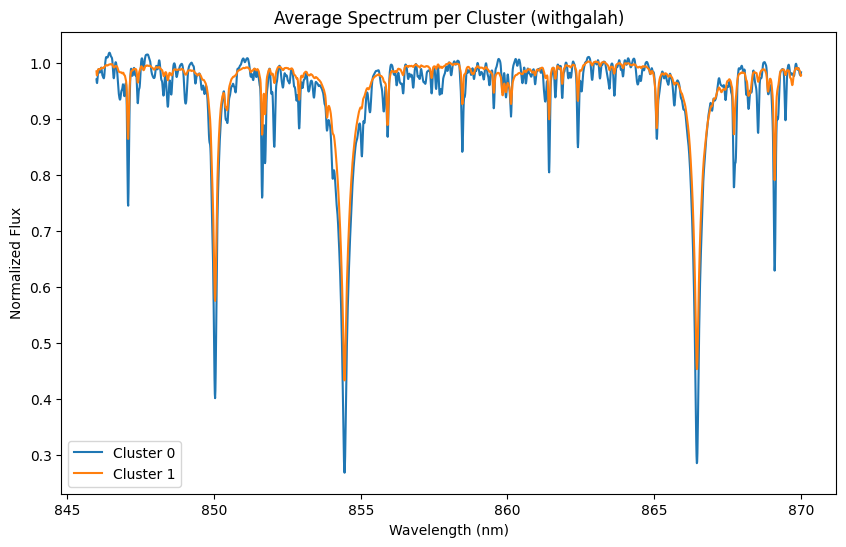

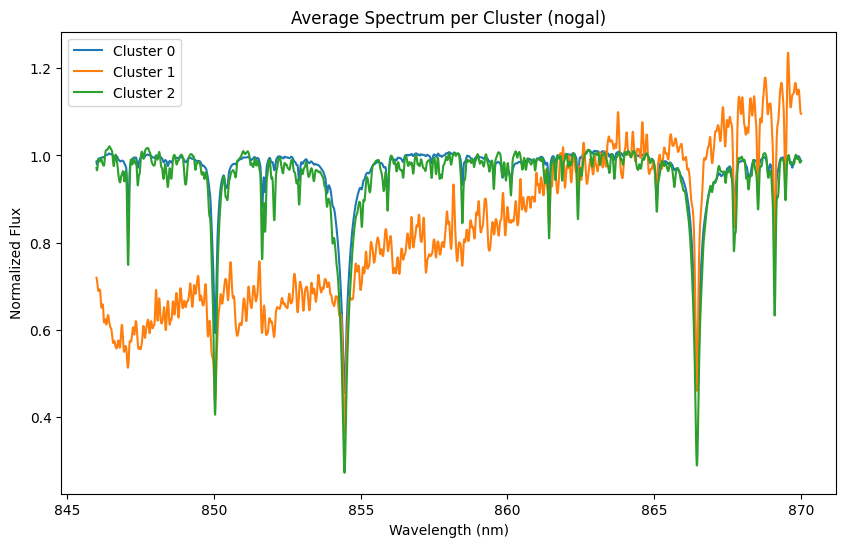

In [61]:
# Withgalah clusters: average spectrum per cluster
unique_clusters_withgalah = np.unique(clusters_withgalah)
plt.figure(figsize=(10, 6))
for cluster in unique_clusters_withgalah:
    cluster_indices = np.where(clusters_withgalah == cluster)[0]
    avg_spectrum = spectra_withgalah.iloc[cluster_indices].mean(axis=0)
    plt.plot(np.linspace(846, 870, 2401), avg_spectrum, label=f'Cluster {cluster}')
plt.title("Average Spectrum per Cluster (withgalah)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized Flux")
plt.legend()
plt.show()

# Nogalah clusters: average spectrum per cluster
unique_clusters_nogal = np.unique(clusters_nogal)
plt.figure(figsize=(10, 6))
for cluster in unique_clusters_nogal:
    cluster_indices = np.where(clusters_nogal == cluster)[0]
    avg_spectrum = spectraNOgal.iloc[cluster_indices].mean(axis=0)
    plt.plot(np.linspace(846, 870, 2401), avg_spectrum, label=f'Cluster {cluster}')
plt.title("Average Spectrum per Cluster (nogal)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized Flux")
plt.legend()
plt.show()


As we can see here, data on cluster 1 and 2 (on both datasets) are actually quite similar. The difference between them seems to be on fine grained sensitivity of the data. Both data follow the same spectral curve, one has more variation on smaller scale than the other.

The big difference is with the third cluster that we see on nogal dataset. The spectrum clearly has a growing trend on frequency, that seems very unphysical and could indicate a cluster of anomalous observations (maybe some detector problem).

## Anomaly Detection 


Run IsolationForest on the spectraNOGal (in high-dimension, not reduced). Find the 5 most anomalous spectra using the score_samples function, and report them back on the PCA projection plot. Plot as well the 5 spectra. What do you observe? 



#### Anomaly Detection with IsolationForest

Fit IsolationForest on the original high-dimensional data

In [56]:
# Withgalah dataset anomaly detection
iso_withgalah = IsolationForest(random_state=42)
iso_withgalah.fit(spectra_withgalah)
scores_withgalah = iso_withgalah.score_samples(spectra_withgalah)


# Nogalah dataset anomaly detection
iso_nogal = IsolationForest(random_state=42)
iso_nogal.fit(spectraNOgal)
scores_nogal = iso_nogal.score_samples(spectraNOgal)


Identify the 5 most anomalous spectra

In [57]:
anomaly_indices_withgalah = np.argsort(scores_withgalah)[:5]

anomaly_indices_nogal = np.argsort(scores_nogal)[:5]

Project all data into 2D for visualization

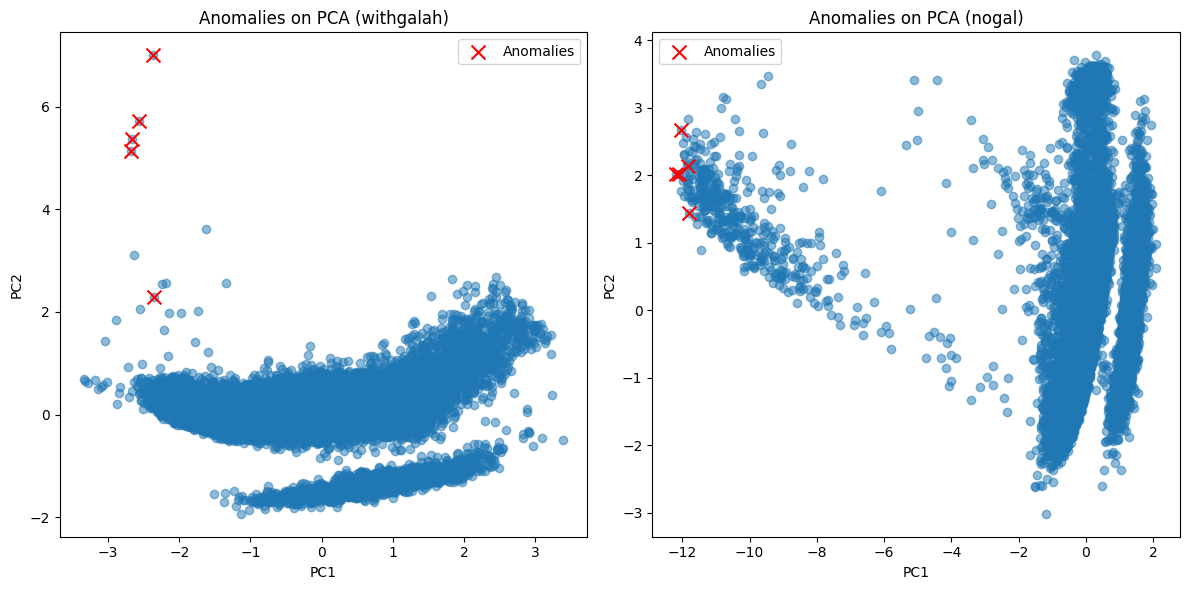

In [58]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(pca_withgalah_2d[:, 0], pca_withgalah_2d[:, 1], alpha=0.5)
plt.scatter(pca_withgalah_2d[anomaly_indices_withgalah, 0],
            pca_withgalah_2d[anomaly_indices_withgalah, 1],
            color='red', marker='x', s=100, label='Anomalies')
plt.title("Anomalies on PCA (withgalah)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(pca_nogal_2d[:, 0], pca_nogal_2d[:, 1], alpha=0.5)
plt.scatter(pca_nogal_2d[anomaly_indices_nogal, 0],
            pca_nogal_2d[anomaly_indices_nogal, 1],
            color='red', marker='x', s=100, label='Anomalies')
plt.title("Anomalies on PCA (nogal)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()

plt.tight_layout()
plt.show()


Here we see that in the withgalah dataset, the most anomalous points are the ones that are isolated from the main clusters.

We will see further ahead

Plot the 5 most anomalous spectra

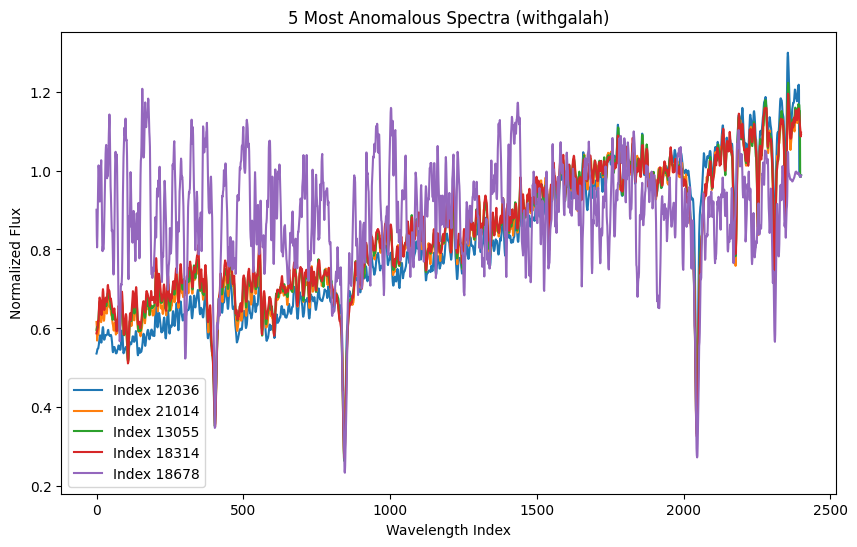

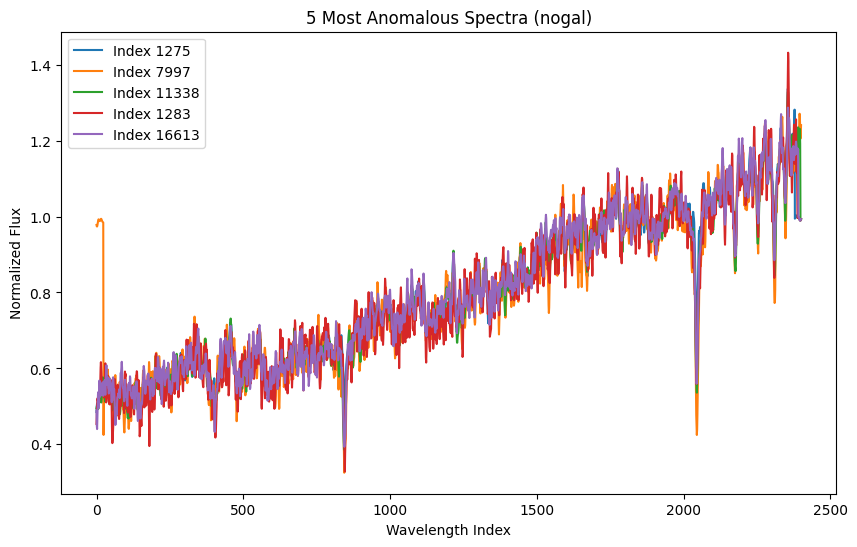

In [59]:
# Plot anomalies for withgalah dataset
plt.figure(figsize=(10, 6))
for idx in anomaly_indices_withgalah:
    plt.plot(spectra_withgalah.iloc[idx], label=f"Index {idx}")
plt.title("5 Most Anomalous Spectra (withgalah)")
plt.xlabel("Wavelength Index")
plt.ylabel("Normalized Flux")
plt.legend()
plt.show()

# Plot anomalies for nogalah dataset
plt.figure(figsize=(10, 6))
for idx in anomaly_indices_nogal:
    plt.plot(spectraNOgal.iloc[idx], label=f"Index {idx}")
plt.title("5 Most Anomalous Spectra (nogal)")
plt.xlabel("Wavelength Index")
plt.ylabel("Normalized Flux")
plt.legend()
plt.show()
